In [1]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch import fit_gpytorch_mll
from botorch.optim import optimize_acqf
import networkx as nx

In [2]:
n = 3
block = np.array([[0,-1],[1,0]])
J = np.kron(np.eye(n, dtype=int),block)
np.random.seed(42)
true_U = np.random.rand(2*n,2*n)
true_U, _ = np.linalg.qr(true_U) #U should be orthonormal
vecs = np.random.rand(500, 2*n) #generate 500 embedding vectors
cur_index = np.random.randint(0,500)

In [3]:
def skew_symmetric_from_vector(x, n):
    """
    Convert a vector x (of length n*(n-1)/2) into an n x n skew-symmetric matrix A.
    The vector x represents the upper-triangular part (excluding the diagonal).
    """
    A = np.zeros((n, n))
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            A[i, j] = x[idx]
            A[j, i] = -x[idx]
            idx += 1
    return A

def objective(x, n):
    """
    Objective function: Frobenius norm of (K - I)^2, where K = exp(A) and A is skew-symmetric.
    """
    A = skew_symmetric_from_vector(x, n)
    K = expm(A)
    I = np.eye(n)
    return norm(K - I, 'fro')**2

def constraint_fun(x, n, v0, v1, L, p):
    """
    Constraint function:
      (K^T v1)^T L (K^T v0) - p = 0,
    where K = exp(A) and A is skew-symmetric.
    """
    A = skew_symmetric_from_vector(x, n)
    K = expm(A)
    Kt = K.T
    # Compute the bilinear form
    constraint_value = (Kt @ v1).T @ L @ (Kt @ v0) - p
    return constraint_value

def solve_for_U(n, v0, v1, L, p, x0=None):
    """
    Solves for the orthogonal matrix K by finding the optimal parameters for A
    (such that K = exp(A)) that minimize ||K - I||_F subject to the constraint.
    
    Parameters:
      n  : dimension of the matrix U (n x n)
      v0 : known vector (n-dimensional)
      v1 : known vector (n-dimensional)
      L  : diagonal matrix (n x n) given as a 2D numpy array
      p  : scalar constraint value
      x0 : optional initial guess for the parameters (default is the zero vector)
      
    Returns:
    U_opt : the optimal orthogonal matrix U satisfying the constraint
      res   : the result object from the optimizer
    """
    # Number of independent parameters in an n x n skew-symmetric matrix.
    m = n * (n - 1) // 2
    if x0 is None:
        x0 = np.zeros(m)  # starting with A = 0, so K = exp(0) = I

    # Define the constraint dictionary for SLSQP
    cons = {'type': 'eq', 'fun': lambda x: constraint_fun(x, n, v0, v1, L, p)}

    # Minimize the objective function subject to the constraint
    res = minimize(lambda x: objective(x, n), x0, method='SLSQP', constraints=cons)

    # Recover the optimal K
    A_opt = skew_symmetric_from_vector(res.x, n)
    U_opt = expm(A_opt)
    return U_opt, res
    #p is true preference value, 0 or 1.
def sigmoid(x):
    return 1/(1+np.exp(-x))
    

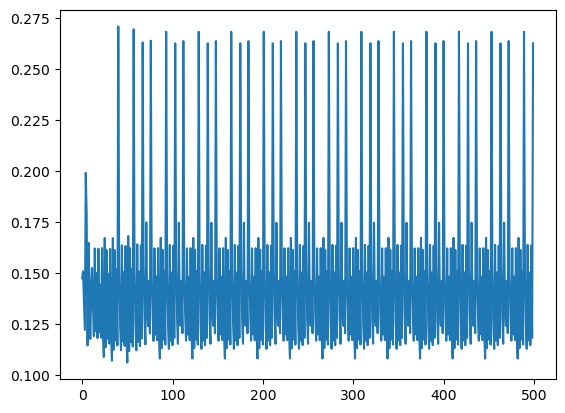

In [4]:
U = np.eye(2*n)
R = J.copy()
true_matrix = true_U @ J @ true_U.T
alpha = 0.1
vals = list()
for _ in range(500):
    best_index = np.argmax(vecs @ R @ vecs[cur_index]) #sigmoid is monotonically increasing, no need to apply
    true_score = true_matrix @ vecs[best_index] @ vecs[cur_index]
    true_score = 0 if true_score <= 0 else 1
    U, _ = solve_for_U(R.shape[-1], vecs[cur_index], vecs[best_index], J, true_score)
    prev_R = R
    R = R + alpha * ((U @ J @ U.T) - R)
    vals.append(np.linalg.norm(R - prev_R, ord='fro'))
plt.plot(vals)

In [5]:
vecs = np.stack([np.arange(1,501),np.arange(2,502)], axis=1) #monotonically decaying function, max is 0

In [6]:
import botorch.acquisition
import gpytorch
def objective_function(index):
    index = int((len(vecs)-1) * index)
    vector = vecs[index]
    weights = vecs @ true_matrix @ vector
    probs = sigmoid(weights)
    return np.max(probs)
init_x = torch.rand(10, dtype=torch.float64)
init_y = torch.tensor([objective_function(x) for x in init_x], dtype=torch.float64).unsqueeze(-1)
init_x = init_x.unsqueeze(-1)
model = SingleTaskGP(train_X=init_x, train_Y=init_y)
dims, tol = 1, 0.05
for i in range(1, 70+1):
    #model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_mll(mll)

    #acquisition_function = LogExpectedImprovement(model=model, best_f=max(init_y), maximize=True)
    beta = 2*np.log((dims * i**2 * torch.pi**2)/(6*tol))
    acquisition_function = botorch.acquisition.analytic.UpperConfidenceBound(model, beta/5, maximize=False)

    candidates, acquisition_value = optimize_acqf(acq_function=acquisition_function,
                                                  bounds = torch.tensor([[0. for _ in range(dims)], [1. for _ in range(dims)]]),
                                                  q=1,
                                                  num_restarts=3,
                                                  raw_samples=128,
                                                  options={"batch_limit": 5, "maxiter": 10})
    #print(candidates[0])
    next_result = torch.tensor(objective_function(candidates[0])).unsqueeze(-1)
    model = model.condition_on_observations(candidates.to(torch.float64), next_result)
    init_y = torch.cat((init_y, next_result.unsqueeze(-1)), dim=0)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 2)

In [ ]:
best_val = model.train_inputs[0][torch.argmin(init_y)]

In [ ]:
int((len(vecs) - 1) * best_val)

In [ ]:
maxes = np.max(vecs @ (vecs @ true_matrix).T, axis=1)
best_candidate = np.argmin(maxes)
loss = (init_y - maxes[best_candidate]).cumsum(0)
plt.plot(loss)

In [ ]:
weights = vecs @ (vecs @ true_matrix).T
probs = sigmoid(weights)
#check ones that are definitively positive and not noise
adjacency = (probs > 0.5).astype(int)
G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)
SCC = nx.strongly_connected_components(G)
list(SCC)